<a href="https://colab.research.google.com/github/shilpasy/Autoencoder-Bioinformatics-examples/blob/main/autoencoder_for_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The code you're looking at is all about making a computer understand and generate handwritten digits. This is something something to understand autoencoders.

Handwritten digits, despite being simple in concept, have inherent complexity due to variations in writing styles. Autoencoders, especially Variational Autoencoders (VAEs), excel at capturing and representing this complexity in a structured manner. Hence they are well-suited for handling the complexity of handwritten digits. They provide a structured and efficient way to represent, generate, and analyze such data.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

# Hyperparameters

In [33]:
batch_size = 100
original_dim = 784  # 28x28 pixels for MNIST images,  Size of a picture
latent_dim = 2  # 2D latent space for easy visualization, like looking at a map
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

# Build the Encoder part of the model

The encoder is a neural network that takes input (x) and transforms it into a latent space representation (z_mean and z_log_var).

The latent space is a lower-dimensional, compact representation of the input data.

It captures the essential features and patterns of the input in a more condensed form.

In [34]:
x = Input(shape=(original_dim,)) #28x28 pixels for MNIST images
h = Dense(intermediate_dim, activation='relu')(x) #compression
z_mean = Dense(latent_dim)(h) #2D
z_log_var = Dense(latent_dim)(h)

**Trick to generate random numbers in a smart way**

In summary, the random numbers are used for sampling during both the training phase (to learn the distribution) and the generation phase (to explore and create new samples). This process helps the VAE to generate novel and diverse outputs while ensuring that the generated samples are coherent with the learned distribution of the training data.

In [35]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

#Build the Decoder part of the model

The decoder is another neural network that takes the latent space representation (z) and reconstructs the original input (x_decoded_mean).

In [36]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [37]:
# Combine the Encoder and Decoder to form the VAE model
vae = Model(x, x_decoded_mean)

**The VAE is formed by combining the encoder and decoder**

The loss function is defined as a combination of reconstruction loss (xent_loss) and KL divergence (kl_loss).

In [38]:
# Define the loss function for training the model
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

In [39]:
# Attach the loss to the model and compile it
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_7 (Dense)             (None, 256)                  200960    ['input_4[0][0]']             
                                                                                                  
 dense_8 (Dense)             (None, 2)                    514       ['dense_7[0][0]']             
                                                                                                  
 dense_9 (Dense)             (None, 2)                    514       ['dense_7[0][0]']             
                                                                                            

In [40]:
# Load and prepare the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

The VAE practices on thousands of handwritten numbers from MNIST, adjusting itself to get better and better at summarizing and recreating them. It does this over and over again (epoch) until it becomes really good at understanding how handwritten numbers work.


# Train the VAE model

In [41]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Epoch 1/50
600/600 [==============================] - 3s 4ms/step - loss: 191.3230 - val_loss: 172.7393
Epoch 2/50
600/600 [==============================] - 2s 3ms/step - loss: 169.9178 - val_loss: 168.0271
Epoch 3/50
600/600 [==============================] - 2s 4ms/step - loss: 166.6371 - val_loss: 165.6275
Epoch 4/50
600/600 [==============================] - 3s 4ms/step - loss: 164.5629 - val_loss: 163.8275
Epoch 5/50
600/600 [==============================] - 2s 4ms/step - loss: 162.8727 - val_loss: 162.2108
Epoch 6/50
600/600 [==============================] - 2s 3ms/step - loss: 161.3550 - val_loss: 160.7481
Epoch 7/50
600/600 [==============================] - 2s 3ms/step - loss: 160.0277 - val_loss: 159.8080
Epoch 8/50
600/600 [==============================] - 2s 4ms/step - loss: 158.9323 - val_loss: 158.5750
Epoch 9/50
600/600 [==============================] - 2s 3ms/step - loss: 158.1409 - val_loss: 157.9909
Epoch 10/50
600/600 [==============================] - 3s 5ms/st

In [42]:
# Build a model to project inputs onto the latent space (Encoder)
encoder = Model(x, z_mean)

A separate model (encoder) is created to project inputs onto the latent space for visualization.

Once it's trained, the VAE can show us where it thinks each number belongs on a map. It's like a map where similar numbers are close to each other. This helps us see how the computer understands and organizes the different handwritten digits.

100/100 [==============================] - 0s 3ms/step


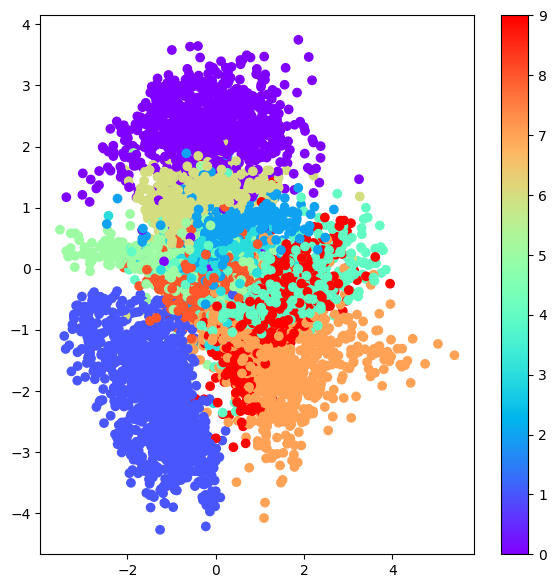

In [52]:
# Visualize a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(7, 7))
#plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='rainbow')  # Adjust the cmap if needed

plt.colorbar()
plt.show()

The VAE can also be creative! It can generate new numbers that look similar to the ones it learned. It's like the computer artist showing us what it thinks a new, never-seen-before number might look like based on what it learned from the training.

In [44]:
# Build a generator that can create new digits from the learned distribution (Decoder)
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [ ]:
# Visualize a 2D grid of generated digits
n = 15
digit_size = 28
all_digits_generated = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        all_digits_generated[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

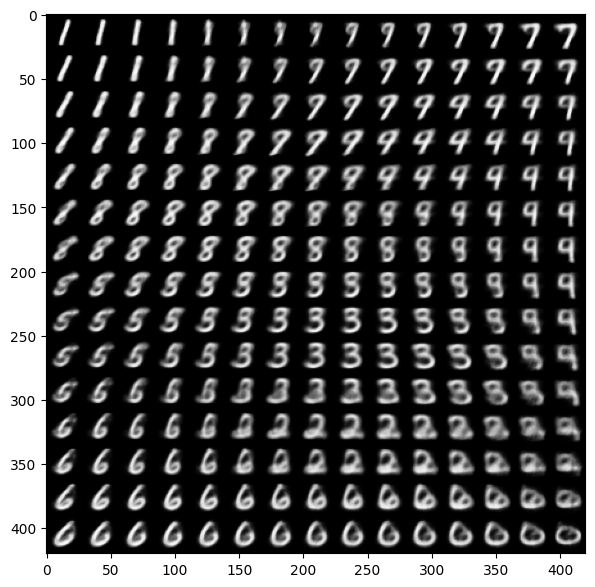

In [46]:
plt.figure(figsize=(7, 7))
plt.imshow(all_digits_generated, cmap='Greys_r')
plt.show()

You can observe here that 1, 7 are quite similar and so are 3, 8 and 6, 0.